# Development of DeepLabV3 Semantic Segmentation Workflow

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import sys
sys.path.append('/jcDataStore/Projects/NeuroTK-Dash')

from os.path import join, basename
from glob import glob
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Normalize
from typing import Optional
import numpy as np
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from neurotk import imread
from neurotk.torch.datasets import BinarySSDataset
from neurotk.torch.models import deeplabv3_model
from neurotk.torch.metrics import binary_dice_coefficient

In [3]:
# Create dataframe to use for initiating Datasets.
src_dir = \
    '/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detection/gray-matter-dataset'

df = []

for fp in glob(join(src_dir, 'images/*.png')):
    df.append([fp, join(src_dir, 'masks', basename(fp))])

df = DataFrame(df, columns=['fp', 'label'])
df.head()

,fp,label
0,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...
1,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...
2,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...
3,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...
4,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...,/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detec...


In [4]:
# Parameters
batch_size = 8
epochs = 50
val_frac = 0.1  # fraction of images to set as validation
random_state = 64  # set to None to keep it random
lr = 1e-4  # learning rate, something small like 1e-4
device = None  # will default to first GPU or CPU if not available

In [5]:
# Initialize model.
model = deeplabv3_model()

In [6]:
# RGB image should be normalized for use in DeepLabV3.
# Instructions: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Specify transforms - these will be applied to the image and mask*
transforms = Compose([ToTensor()])

In [7]:
# Split the data into train and val.
train_df, val_df = train_test_split(df, test_size=val_frac, 
                                    random_state=random_state)

# Create dataloaders, set as dictionary with 'train' and 'val'.
# Will wrap this into a function later.
dataloaders = {
    'train': DataLoader(
        BinarySSDataset(train_df, transforms=transforms, norm=norm), 
        batch_size=batch_size, 
        shuffle=True
    ),
    'val': DataLoader(
        BinarySSDataset(val_df, transforms=transforms, norm=norm), 
        batch_size=batch_size, 
        shuffle=False
    )
}

In [8]:
# Train model - needs to be finalized.
def train_binary_ss_model(
    model, 
    dataloaders: dict,
    criterion,  
    optimizer, 
    metrics: dict, 
    epochs: int = 10,
    device: Optional[str] = None
):
    """Train a semantic segmentation model were the masks / labels only
    contains 0 and 1 values (background and positive class).
    
    Args:
        model: Model that will predict probability masks, i.e. pixel wise
            predictions.
        dataloaders: Contains dataloaders at the 'train' and 'val' keys.
        criterion: PyTorch criterion to calculate loss.
        optimizer: Determine backpropagation strategy.
        metrics: Metrics that have the update, reset, and compute methods.
        epochs: Number of epochs to train to.
        device: Specify device to use, otherwise it will use the first 
            cuda device available otherwise cpu.

    Returns:
        Trained model.
        
    """
    # best_model_wts = deepcopy(model.state_dict())
    # best_loss = 1e10  # initiate loss very large

    if device is None:
        # By default use the first GPU if available.
        device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu"
        )
    
    model.to(device)
    
    for epoch in range(1, epochs + 1):
        epoch_str = f'Epoch {epoch} of {epochs}'
        print(epoch_str)
        print('-' * len(epoch_str))

        for phase in ['train', 'val']:
            # Set model to appropriate state.
            model.train() if phase == 'train' else model.eval()

            # reset metrics
            for metric in metrics.values():
                metric.reset()

            # Iterate through batches.
            epoch_loss = []
            
            for sample in dataloaders[phase]:
                # Send input and label masks to same device as model.
                inputs = sample['image'].to(device)
                targets = sample['mask'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Predict the masks.
                    outputs = model(inputs)

                    # Calculate the loss.
                    loss = criterion(outputs['out'], targets)

                    # Backpropagation and step the optimizer.
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Update metrics.
                    for metric in metrics.values():
                        metric.update(
                            outputs['out'], 
                            targets
                        )

                    epoch_loss.append(loss.data.cpu())

            # Report epoch loss and metrics.
            # JC: still hard coded in the metric.
            print(
                f'{phase}, '
                f'   loss: {np.mean(epoch_loss): .4f},'
                f'   dice coefficient: {metrics["Dice Coefficient"].compute():.4f}'
            )                
        print()

    return model


# Parameters

# Optimizer gets fed in the model parameters and learning rate.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')

# Specify the metric.
metrics = {'Dice Coefficient': binary_dice_coefficient()}

_ = train_binary_ss_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    metrics,
    epochs=epochs,
    device=device
)

Epoch 1 of 50
-------------
train,    loss:  0.3382,   dice coefficient: 0.5423
val,    loss:  0.7558,   dice coefficient: 0.5772

Epoch 2 of 50
-------------
train,    loss:  0.1083,   dice coefficient: 0.6074
val,    loss:  0.1005,   dice coefficient: 0.6441

Epoch 3 of 50
-------------
train,    loss:  0.0771,   dice coefficient: 0.6844
val,    loss:  0.0889,   dice coefficient: 0.6939

Epoch 4 of 50
-------------
train,    loss:  0.0639,   dice coefficient: 0.7116
val,    loss:  0.0967,   dice coefficient: 0.7284

Epoch 5 of 50
-------------
train,    loss:  0.0526,   dice coefficient: 0.7506
val,    loss:  0.0816,   dice coefficient: 0.7400

Epoch 6 of 50
-------------
train,    loss:  0.0472,   dice coefficient: 0.7695
val,    loss:  0.0764,   dice coefficient: 0.7396

Epoch 7 of 50
-------------
train,    loss:  0.0413,   dice coefficient: 0.7890
val,    loss:  0.0677,   dice coefficient: 0.7397

Epoch 8 of 50
-------------
train,    loss:  0.0389,   dice coefficient: 0.7976
val

## Visualize some predictions.

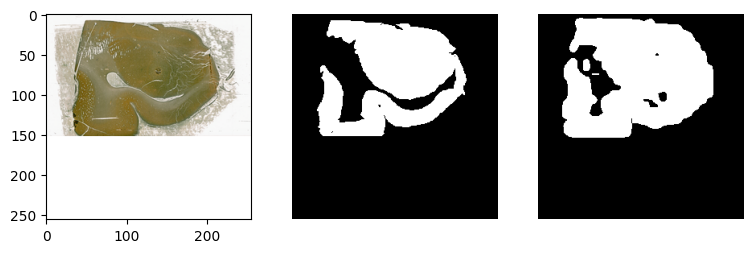

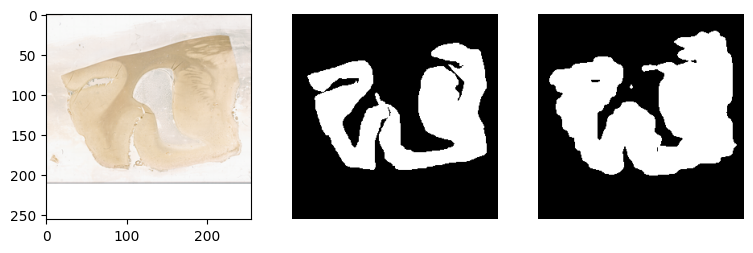

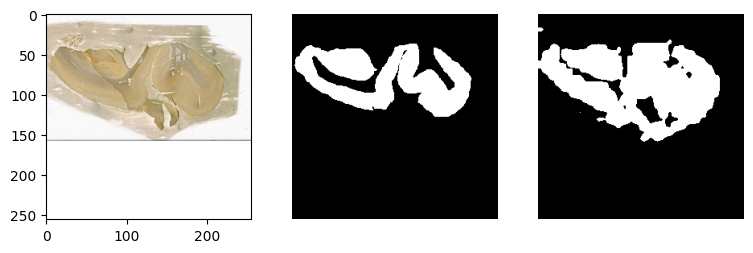

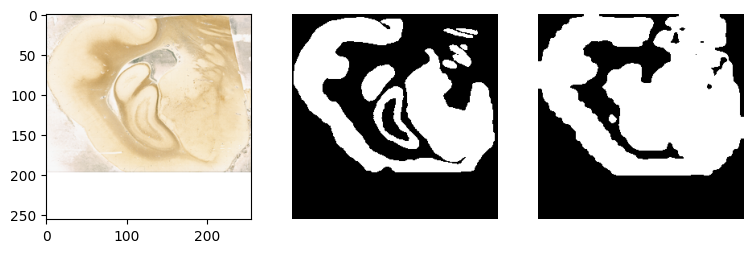

In [21]:
device = torch.device("cuda:0")
model.eval()
model.to(device)

# Create a val dataloader with shuffle, modify how many images to show
# with batch size.
dataloader = DataLoader(
    BinarySSDataset(val_df, transforms=transforms, norm=norm), 
    batch_size=4, 
    shuffle=True
)

sample = next(iter(dataloader))

image = sample['image'].to(device)
mask = sample['mask'].to(device)

with torch.set_grad_enabled(False):
    output = model(image)

    # Convert probabilities to binary mask.
    pred = output['out'] > 0.1
    
    for i in range(pred.shape[0]):
        # Plot the image, true mask, and prediction.
        fig = plt.figure(figsize=(9, 4))
        fig.add_subplot(1, 3, 1)

        img = imread(sample['info']['fp'][i])
        plt.imshow(img)

        fig.add_subplot(1, 3, 2)
        m = imread(sample['info']['label'][i])
        plt.imshow(m)
        plt.axis('off')

        fig.add_subplot(1, 3, 3)

        p = pred[i][0].data.cpu().numpy()

        plt.imshow(p, cmap='gray')
        plt.axis('off')
        plt.show()